# Comparing Kernel Ridge and Gaussian Process

In this notebook, we will make some small exercises to check the difference between some ridge regressors and gaussian process models.

Firs, we create a synthetic dataset. The true generative process will take a 1-D
vector and compute its sine. Note that the period of this sine is thus
$2 \pi$. We will reuse this information later in this example.

In [1]:
import numpy as np

rng = np.random.RandomState(0)
data = np.linspace(0, 30, num=1_000).reshape(-1, 1)
target = np.sin(data).ravel()

Now, we can imagine a scenario where we get observations from this true
process. However, we will add some challenges:

- the measurements will be noisy;
- only samples from the beginning of the signal will be available.

In [2]:
training_sample_indices = rng.choice(np.arange(0, 400), size=40, replace=False)
training_data = data[training_sample_indices]
training_noisy_target = target[training_sample_indices] + 0.5 * rng.randn(
    len(training_sample_indices)
)

Let's plot the true signal and the noisy measurements available for training.

In [3]:
import sklearn
import seaborn as sns
sns.set_context("talk")
sklearn.set_config(display="diagram")

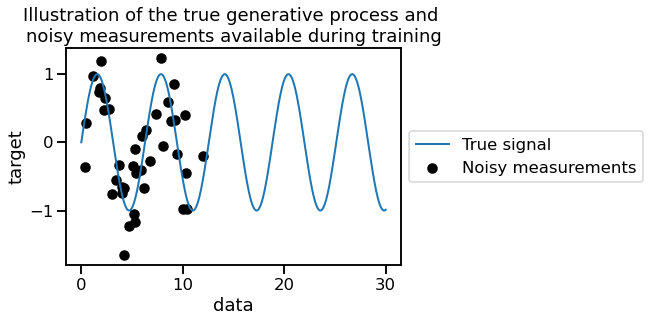

In [4]:
import matplotlib.pyplot as plt

plt.plot(data, target, label="True signal", linewidth=2)
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title(
    "Illustration of the true generative process and \n"
    "noisy measurements available during training"
)

## Limitations of a simple linear model

First, we would like to highlight the limitations of a linear model given
our dataset. We fit a `Ridge` and check the
predictions of this model on our dataset.

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    <ul>
        <li>Fit a <tt>Ridge</tt> model on the training samples.</li>
        <li>Predict with the trained model for all data point.</li>
    </ul>
    What is the limitation of the <tt>Ridge</tt> model?
    <br>
    How could you bypass these limitation?
</div>

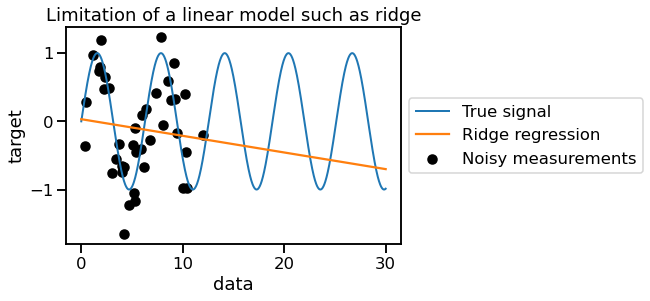

In [5]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(training_data, training_noisy_target)

plt.plot(data, target, label="True signal", linewidth=2)
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.plot(data, ridge.predict(data), label="Ridge regression")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title("Limitation of a linear model such as ridge")

Such a ridge regressor underfits data since it is not expressive enough.

## Kernel methods: kernel ridge and Gaussian process

### Kernel ridge

We previously saw that we could make a linear model more expressive notably by using kernel approximation. Here, we will even use the "kernel trick" in conjuction with `Ridge`. Indeed, scikit-learn propose the `KernelRidge` regressor that accept any type of kernel, similarly to SVM.

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    <ul>
        <li>Fit a <tt>KernelRidge</tt> using a <tt>ExpSineSquared</tt> kernel, all with default parameters.</li>
        <li>Measure the time to fit the model.</li>
        <li>Plot the predictions for the entire dataset.</li>
    </ul>
    Is there any issue with the model? How to solve them, is there is any?
</div>

In [6]:
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.kernel_ridge import KernelRidge

kernel_ridge = KernelRidge(kernel=ExpSineSquared())

In [7]:
%%time
kernel_ridge.fit(training_data, training_noisy_target)

CPU times: user 1.07 ms, sys: 534 µs, total: 1.6 ms
Wall time: 1.24 ms


KernelRidge(kernel=ExpSineSquared(length_scale=1, periodicity=1))

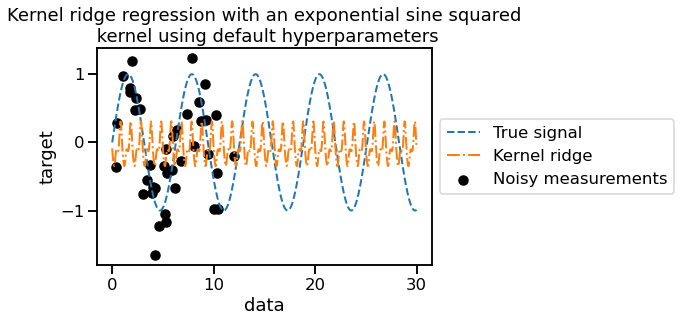

In [8]:
plt.plot(data, target, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.plot(
    data,
    kernel_ridge.predict(data),
    label="Kernel ridge",
    linewidth=2,
    linestyle="dashdot",
)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title(
    "Kernel ridge regression with an exponential sine squared\n "
    "kernel using default hyperparameters"
)

This fitted model is not accurate. Indeed, we did not set the parameters of
the kernel and instead used the default ones. We can inspect them.

In [9]:
kernel_ridge.kernel

ExpSineSquared(length_scale=1, periodicity=1)

Our kernel has two parameters: the length-scale and the periodicity. For our
dataset, we use `sin` as the generative process, implying a
$2 \pi$-periodicity for the signal. The default value of the parameter
being $1$, it explains the high frequency observed in the predictions of
our model.
Similar conclusions could be drawn with the length-scale parameter. Thus, it
tell us that the kernel parameters need to be tuned. We will use a randomized
search to tune the different parameters the kernel ridge model: the `alpha`
parameter and the kernel parameters.

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    Using the previous information
    <ul>
        <li>Create a <tt>RandomizedSearchCV</tt> and tune the parameter of the kernel and the regularization parameters.</li>
        <li>Measure the time to fit the model.</li>
        <li>Plot the predictions for the entire dataset.</li>
    </ul>
    Is the model properly fitting the data? What is the computational cost of the model?
</div>

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

param_distributions = {
    "alpha": loguniform(1e0, 1e3),
    "kernel__length_scale": loguniform(1e-2, 1e2),
    "kernel__periodicity": loguniform(1e0, 1e1),
}
kernel_ridge_tuned = RandomizedSearchCV(
    kernel_ridge,
    param_distributions=param_distributions,
    n_iter=500,
    random_state=0,
)

In [11]:
%%time
kernel_ridge_tuned.fit(training_data, training_noisy_target)

CPU times: user 1.03 s, sys: 11.6 ms, total: 1.04 s
Wall time: 1.03 s


RandomizedSearchCV(estimator=KernelRidge(kernel=ExpSineSquared(length_scale=1, periodicity=1)),
                   n_iter=500,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1354be0a0>,
                                        'kernel__length_scale': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1354be430>,
                                        'kernel__periodicity': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1354be670>},
                   random_state=0)

Fitting the model is now more computationally expensive since we have to try
several combinations of hyperparameters. We can have a look at the
hyperparameters found to get some intuitions.

In [12]:
kernel_ridge_tuned.best_params_

{'alpha': 1.9915849773450223,
 'kernel__length_scale': 0.7986499491396728,
 'kernel__periodicity': 6.607275806426108}

Looking at the best parameters, we see that they are different from the
defaults. We also see that the periodicity is closer to the expected value $2 \pi$. We can now inspect the predictions of our tuned kernel ridge.

In [13]:
%%time
predictions_kr = kernel_ridge_tuned.predict(data)

CPU times: user 2.47 ms, sys: 1.59 ms, total: 4.05 ms
Wall time: 2.47 ms


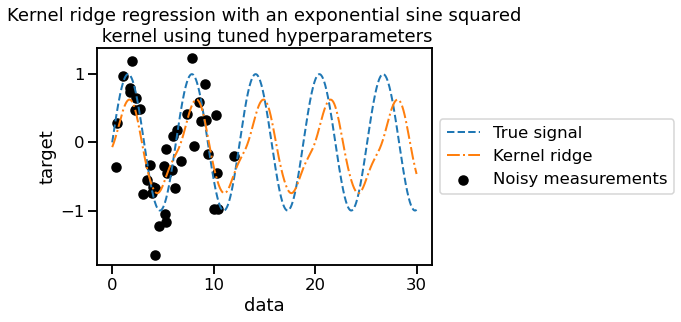

In [14]:
plt.plot(data, target, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.plot(
    data,
    predictions_kr,
    label="Kernel ridge",
    linewidth=2,
    linestyle="dashdot",
)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title(
    "Kernel ridge regression with an exponential sine squared\n "
    "kernel using tuned hyperparameters"
)

We get a much more accurate model. We still observe some errors mainly due to
the noise added to the dataset.

## Gaussian process regression

Now, we will use a
`GaussianProcessRegressor` to fit the same
dataset. When training a Gaussian process, the hyperparameters of the kernel
are optimized during the fitting process. There is no need for an external
hyperparameter search. Here, we create a slightly more complex kernel than
for the kernel ridge regressor: we add a
`WhiteKernel` that is used to
estimate the noise in the dataset.

In [15]:
from sklearn.gaussian_process.kernels import WhiteKernel

kernel = 1.0 * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) + WhiteKernel(
    1e-1
)

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    Using the kernel defined above,
    <ul>
        <li>Create a <tt>GaussianProcessRegressor</tt></li>
        <li>Measure the time to fit the model.</li>
        <li>Plot the predictions for the entire dataset.</li>
    </ul>
    Is the model properly fitting the data? What is the computational cost of the model?
</div>

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor

gaussian_process = GaussianProcessRegressor(kernel=kernel)

In [17]:
%%time
gaussian_process.fit(training_data, training_noisy_target)

CPU times: user 81.1 ms, sys: 52.1 ms, total: 133 ms
Wall time: 38.2 ms


GaussianProcessRegressor(kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=5) + WhiteKernel(noise_level=0.1))

The computation cost of training a Gaussian process is much less than the
kernel ridge that uses a randomized search. We can check the parameters of
the kernels that we computed.

In [18]:
gaussian_process.kernel_

0.675**2 * ExpSineSquared(length_scale=1.34, periodicity=6.57) + WhiteKernel(noise_level=0.182)

Indeed, we see that the parameters have been optimized. Looking at the
`periodicity` parameter, we see that we found a period close to the
theoretical value :math:`2 \pi`. We can have a look now at the predictions of
our model.

In [19]:
%%time
mean_predictions_gpr, std_predictions_gpr = gaussian_process.predict(
    data,
    return_std=True,
)

CPU times: user 3.91 ms, sys: 1.94 ms, total: 5.85 ms
Wall time: 4.18 ms


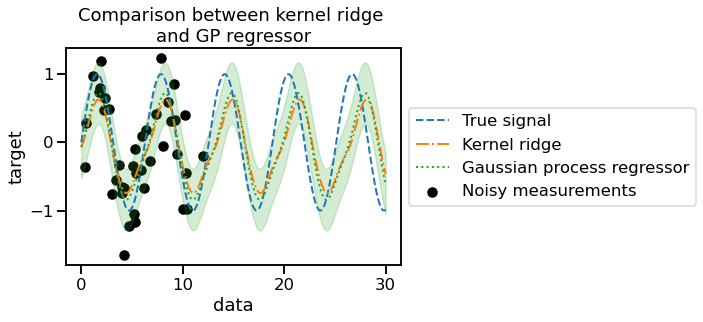

In [20]:
plt.plot(data, target, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
# Plot the predictions of the kernel ridge
plt.plot(
    data,
    predictions_kr,
    label="Kernel ridge",
    linewidth=2,
    linestyle="dashdot",
)
# Plot the predictions of the gaussian process regressor
plt.plot(
    data,
    mean_predictions_gpr,
    label="Gaussian process regressor",
    linewidth=2,
    linestyle="dotted",
)
plt.fill_between(
    data.ravel(),
    mean_predictions_gpr - std_predictions_gpr,
    mean_predictions_gpr + std_predictions_gpr,
    color="tab:green",
    alpha=0.2,
)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title("Comparison between kernel ridge \nand GP regressor")

We observe that the results of the kernel ridge and the Gaussian process
regressor are close. However, the Gaussian process regressor also provide
an uncertainty information that is not available with a kernel ridge.
Due to the probabilistic formulation of the target functions, the
Gaussian process can output the standard deviation (or the covariance)
together with the mean predictions of the target functions.

However, it comes at a cost: the time to compute the predictions is higher
with a Gaussian process.

## Final conclusion

We can give a final word regarding the possibility of the two models to
extrapolate. Indeed, we only provided the beginning of the signal as a
training set. Using a periodic kernel forces our model to repeat the pattern
found on the training set. Using this kernel information together with the
capacity of the both models to extrapolate, we observe that the models will
continue to predict the sine pattern.

Gaussian process allows to combine kernels together. Thus, we could associate
the exponential sine squared kernel together with a radial basis function
kernel.

In [21]:
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) * RBF(
    length_scale=15, length_scale_bounds="fixed"
) + WhiteKernel(1e-1)
gaussian_process = GaussianProcessRegressor(kernel=kernel)
gaussian_process.fit(training_data, training_noisy_target)
mean_predictions_gpr, std_predictions_gpr = gaussian_process.predict(
    data,
    return_std=True,
)

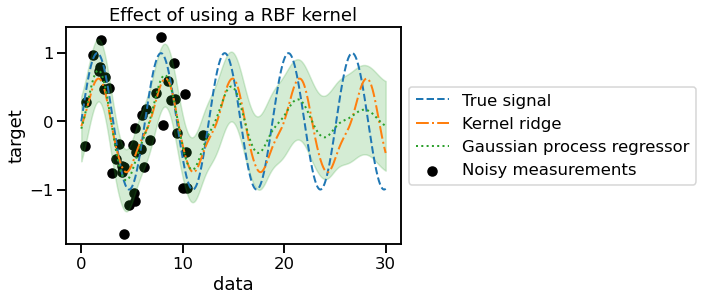

In [22]:
plt.plot(data, target, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
# Plot the predictions of the kernel ridge
plt.plot(
    data,
    predictions_kr,
    label="Kernel ridge",
    linewidth=2,
    linestyle="dashdot",
)
# Plot the predictions of the gaussian process regressor
plt.plot(
    data,
    mean_predictions_gpr,
    label="Gaussian process regressor",
    linewidth=2,
    linestyle="dotted",
)
plt.fill_between(
    data.ravel(),
    mean_predictions_gpr - std_predictions_gpr,
    mean_predictions_gpr + std_predictions_gpr,
    color="tab:green",
    alpha=0.2,
)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title("Effect of using a RBF kernel")

The effect of using a radial basis function kernel will attenuate the
periodicity effect once that no sample are available in the training.
As testing samples get further away from the training ones, predictions
are converging towards their mean and their standard deviation
also increases.